<a href="https://colab.research.google.com/github/neel26desai/cmpe255_assignment2/blob/main/Time_Series_Forecasting_with_Exogenous_Variable_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret

We will be performing Forecasting on the closing Amazon stock price. In this example we will be using Exogenous Variables

Dataset: https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
#reading the data
df = pd.read_csv('/content/drive/MyDrive/AMZN_2006-01-01_to_2018-01-01.csv')

In [ ]:
print(df.shape)
df.info()

(3019, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [ ]:
#converting the date column to timestamp
df['Date']= pd.to_datetime(df['Date'])
#setting the date column to be the index
df.set_index('Date',inplace=True)
#as the name will be same for all rows we can go ahead and drop it
df.drop(['Name'],axis=1,inplace=True)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 141.5 KB
None
             Open   High    Low  Close   Volume
Date                                           
2006-01-03  47.47  47.85  46.25  47.58  7582127
2006-01-04  47.48  47.73  46.69  47.25  7440914
2006-01-05  47.16  48.20  47.11  47.65  5417258
2006-01-06  47.97  48.58  47.32  47.87  6154285
2006-01-09  46.55  47.10  46.40  47.08  8945056


In [ ]:
# initalize Time Series Forecasting Experiment
from pycaret.time_series import TSForecastingExperiment
exp = TSForecastingExperiment()

In [ ]:
#we need to convert the timeseries dataframe into monthly intervals
df = df.asfreq('M')

In [ ]:
#set up pycaret, fh determines how long you want to forecast for in our case 12 month, the imputation parameter tells the set up that incase of missing values in target or exogenous fill them using forward fill
exp.setup(data=df, target='Close' ,fh=12, session_id=152,numeric_imputation_target="ffill", numeric_imputation_exogenous='ffill')

,Description,Value
0,session_id,152
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(143, 5)"
5,Transformed data shape,"(143, 5)"
6,Transformed train set shape,"(131, 5)"
7,Transformed test set shape,"(12, 5)"
8,Rows with missing values,28.7%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
#let us view the timeseries
exp.plot_model(plot='ts')

In [ ]:
#create baseline models
baseline_models = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.0892,0.0851,2.1285,2.8479,0.0048,0.0048,0.9975,3.6600
arima,ARIMA,0.1249,0.1065,3.1246,3.7157,0.0064,0.0063,0.9969,0.3733
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.7201,1.6682,41.4812,55.0578,0.0797,0.0842,0.3938,0.5567
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,2.0373,1.8493,49.4946,61.3904,0.0991,0.1009,0.0240,1.2400
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.1303,1.9542,51.5139,64.3506,0.1046,0.1062,-0.1149,0.4900
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,2.2524,2.0177,53.8273,65.9087,0.1076,0.1178,0.1779,0.5600
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,2.3851,2.2263,56.7336,71.1570,0.1133,0.1232,-0.2274,0.4267
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.4634,2.2183,59.0693,72.1670,0.1272,0.1235,-1.2564,0.6900
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,2.6033,2.2822,64.7168,78.1450,0.1209,0.1282,-0.3379,1.2400
naive,Naive Forecaster,3.5695,3.1579,85.1814,102.3821,0.1698,0.1893,-1.1373,2.1933


Processing:   0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
#plot the best model
exp.plot_model(baseline_models)

In [ ]:
#finalizing the model
final_model = exp.finalize_model(baseline_models)

In [ ]:
#creating a safe predict function as along with time we would aslo need to procide exo variables for forecasting in future
def generate_exog_var_data_models(exp):
    exog_vars = exp.exogenous_variables
    print(f'Need the following exogenous variables for making the prediction {exog_vars}')
    #creating models to generate the future values of all exo variables
    exog_exps=[]
    exog_models=[]
    temp = df.copy()
    #drop the Close
    temp.drop(['Close'],axis=1,inplace=True)
    for exog_var in exog_vars:
      exog_exp = TSForecastingExperiment()
      exog_exp.setup(temp[exog_var],target=exog_var,fh=12,numeric_imputation_target="ffill",numeric_imputation_exogenous="ffill",session_id=152)
      best = exog_exp.compare_models()
      final_exog_model = exog_exp.finalize_model(best)
      exog_exps.append(exog_exp)
      exog_models.append(final_exog_model)
    return exog_exps,exog_models

def apply_exog_models(exp, exog_exps,exog_models):
    #use the models created to generate future predictions for exog variables
    future_exog=[
        exog_exp.predict_model(exog_model)
        for exog_exp,exog_model in zip(exog_exps,exog_models)
    ]
    future_exog = pd.concat(future_exog,axis=1)
    future_exog.columns = exp.exogenous_variables
    return future_exog



In [ ]:
exog_exps,exog_models = generate_exog_var_data_models(exp)

Need the following exogenous variables for making the prediction ['Open', 'High', 'Low', 'Volume']


,Description,Value
0,session_id,152
1,Target,Open
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(143, 1)"
5,Transformed data shape,"(143, 1)"
6,Transformed train set shape,"(131, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,28.7%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,2.4957,2.4688,60.6093,80.6842,0.1319,0.1310,-1.1278,0.3500
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,2.6279,2.4537,64.8871,82.0201,0.1286,0.1388,-0.2173,0.4900
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,2.8151,2.5783,70.4048,87.3336,0.1366,0.1460,-0.3592,0.6500
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,2.8153,2.5782,70.4259,87.3421,0.1366,0.1460,-0.3586,0.3500
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,2.8155,2.5785,70.4160,87.3418,0.1366,0.1460,-0.3595,0.6267
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,2.8306,2.5867,70.8935,87.7226,0.1372,0.1465,-0.3687,0.4133
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,2.8308,2.5867,70.8976,87.7260,0.1372,0.1465,-0.3688,0.3533
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,2.8824,2.6433,71.5217,88.8253,0.1420,0.1515,-0.4815,0.3500
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,3.1939,2.9070,76.7129,93.7370,0.1629,0.1768,-1.2316,0.4300
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,3.2594,2.9853,78.5463,96.7648,0.1678,0.1781,-1.5091,0.4467


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

,Description,Value
0,session_id,152
1,Target,High
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(143, 1)"
5,Transformed data shape,"(143, 1)"
6,Transformed train set shape,"(131, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,28.7%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,2.7167,2.5132,66.6480,83.8053,0.1317,0.1417,-0.2612,0.6000
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,2.9041,2.6338,72.2143,89.0350,0.1396,0.1487,-0.3964,0.5933
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,2.9045,2.6340,72.2255,89.0433,0.1396,0.1487,-0.3967,0.6167
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,2.9066,2.6355,72.2814,89.0956,0.1397,0.1488,-0.3993,0.3533
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,2.9233,2.6454,72.7733,89.5124,0.1404,0.1494,-0.4123,0.3800
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,2.9234,2.6455,72.7772,89.5156,0.1404,0.1494,-0.4124,0.3433
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,2.9787,2.7026,73.6277,90.8019,0.1448,0.1541,-0.5129,0.3400
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,3.1314,2.8629,75.0488,92.7248,0.1605,0.1667,-1.4061,0.3533
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,3.3466,3.0527,80.1268,98.6304,0.1702,0.1807,-1.5527,0.4333
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,3.3537,3.0427,80.2337,98.3028,0.1710,0.1813,-1.5524,0.8300


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

,Description,Value
0,session_id,152
1,Target,Low
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(143, 1)"
5,Transformed data shape,"(143, 1)"
6,Transformed train set shape,"(131, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,28.7%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,2.6050,2.4589,62.6387,79.6936,0.1271,0.1376,-0.2279,1.3233
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,2.7595,2.5641,67.0996,84.0879,0.1336,0.1435,-0.3300,0.7467
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,2.7596,2.5643,67.1046,84.0928,0.1337,0.1435,-0.3301,0.3767
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,2.7600,2.5648,67.1173,84.1135,0.1337,0.1435,-0.3310,0.3467
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,2.7708,2.5725,67.4323,84.4409,0.1341,0.1439,-0.3387,0.3533
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,2.7709,2.5725,67.4349,84.4437,0.1341,0.1439,-0.3388,0.3633
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,2.8417,2.6378,68.6680,85.9276,0.1396,0.1493,-0.4841,0.3433
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,3.3702,3.0428,79.8500,96.5255,0.1724,0.1825,-1.6684,0.6833
theta,Theta Forecaster,3.3832,3.0725,80.9446,98.3615,0.1687,0.1823,-1.3906,0.0833
naive,Naive Forecaster,3.4851,3.1245,84.0458,101.0044,0.1695,0.1893,-1.1060,0.0967


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

,Description,Value
0,session_id,152
1,Target,Volume
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(143, 1)"
5,Transformed data shape,"(143, 1)"
6,Transformed train set shape,"(131, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,28.7%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
polytrend,Polynomial Trend Forecaster,0.3885,0.3731,1264111.5346,2039437.5518,0.3181,0.3044,-0.3956,0.0667
croston,Croston,0.4200,0.3849,1370548.3077,2108643.1574,0.3788,0.3251,-0.5306,0.0633
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.4321,0.3312,1397762.3018,1794309.3230,0.3588,0.3768,-0.9345,0.5300
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.4322,0.3275,1395596.9185,1774352.1128,0.3683,0.3764,-0.8296,1.2100
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.4493,0.3619,1453167.9730,1963149.0335,0.3803,0.3733,-1.1951,0.8233
auto_arima,Auto ARIMA,0.4494,0.4008,1465016.5647,2193362.5731,0.3922,0.3515,-0.6147,3.2767
theta,Theta Forecaster,0.4601,0.4081,1498314.2125,2230658.3459,0.3746,0.3646,-0.8076,0.0900
snaive,Seasonal Naive Forecaster,0.4652,0.4107,1513423.8611,2241538.6032,0.4043,0.3722,-0.8628,0.1267
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.4844,0.4214,1567642.5384,2288259.7347,0.4151,0.3712,-2.0918,0.4267
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.4865,0.4169,1574868.6928,2264214.0181,0.4187,0.3743,-2.0250,0.7200


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
future_pred_data = apply_exog_models(exp,exog_exps,exog_models)

In [ ]:
future_pred = exp.predict_model(final_model,X=future_pred_data)

<Axes: >

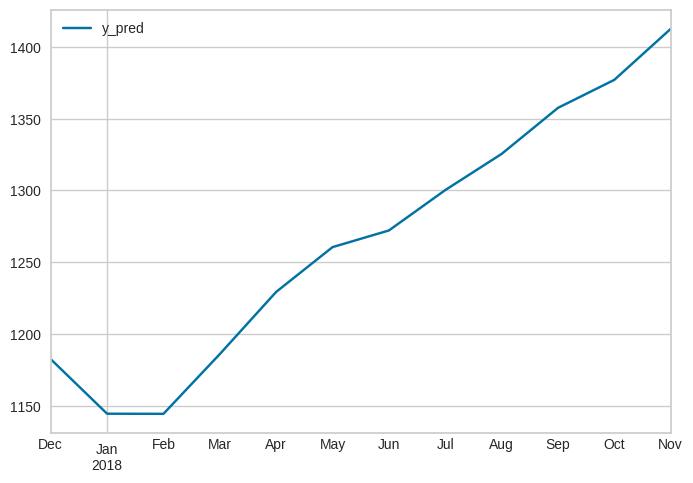

In [ ]:
future_pred.plot()

In [ ]:
#saving the model
exp.save_model(final_model,'./timeseries_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('transformer_exogenous',
                             TransformerPipeline(steps=[('numerical_imputer',
                                                         Imputer(method='ffill',
                                                                 random_state=152))])),
                            ('forecaster',
                             TransformedTargetForecaster(steps=[('transformer_target',
                                                                 TransformerPipeline(steps=[('numerical_imputer',
                                                                                             Imputer(method='ffill',
                                                                                                     random_state=152))])),
                                                                ('model',
                                                                 ForecastingPipeline(steps=[('transformer_exogenous',
                      

Reference

[1] https://github.com/pycaret/pycaret/blob/master/tutorials/time_series/forecasting/univariate_with_exogeneous_part3.ipynb